In [7]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.preprocessing import StandardScaler
from sklearn.inspection import permutation_importance
import tldextract
import matplotlib.pyplot as plt

# Загрузка данных
data = pd.read_csv("Malicious-URLs.csv")

# Удаление дубликатов и пустых значений
data = data.drop_duplicates(subset="url").dropna()

# Проверка баланса классов
print("Распределение классов:")
print(data["label"].value_counts())
data

Распределение классов:
label
benign        10991
defacement     2727
phishing        912
malware         303
Name: count, dtype: int64


,count,url,label
0,0,br-icloud.com.br,phishing
1,1,mp3raid.com/music/krizz_kaliko.html,benign
2,2,bopsecrets.org/rexroth/cr/1.htm,benign
3,3,http://www.garage-pirenne.be/index.php?option=...,defacement
4,4,http://adventure-nicaragua.net/index.php?optio...,defacement
...,...,...,...
14995,14995,fortdefianceind.com/,benign
14996,14996,bookrags.com/lens/go.php?u=Hannah_Webster_Foster,benign
14997,14997,burbankairport.com/parking/buses-trains.html,benign
14998,14998,http://otomoto.pl/oferta/subaru-outback-legacy...,benign


In [8]:
def extract_features(url):
    features = {}
    try:
        # Лексические признаки
        features["url_length"] = len(url)
        features["num_special_chars"] = sum(url.count(c) for c in ['@', '%', '//', '?', '='])
        
        # Анализ домена
        ext = tldextract.extract(url)
        features["subdomain_count"] = len(ext.subdomain.split('.')) if ext.subdomain else 0
        features["domain_length"] = len(ext.domain)
        features["has_ip"] = 1 if any(part.isdigit() for part in ext.domain.split('.')) else 0
        
        # Семантические признаки
        keywords = ['login', 'admin', 'exe', 'php', 'config', 'secure']
        features["keyword_count"] = sum(1 for kw in keywords if kw in url)
        
        return features
    except Exception as e:
        print(f"Ошибка обработки URL {url}: {e}")
        return None

# Применение функции
features = data["url"].apply(extract_features)
valid_indices = features[features.notna()].index
data = data.loc[valid_indices]
features = features.loc[valid_indices]

# Создание DataFrame с признаками
features_df = pd.DataFrame(features.tolist())
labels = data["label"].values

In [9]:
# Нормализация (опционально для Random Forest, но улучшает интерпретацию)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(features_df)

In [10]:
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, 
    labels, 
    test_size=0.2, 
    stratify=labels, 
    random_state=42
)

In [15]:
# Создание и обучение модели
model = RandomForestClassifier(
    n_estimators=100, 
    max_depth=10, 
    random_state=42,
    class_weight={'benign': 1.35,
                   'defacement': 5.48,
                   'phishing': 6.8,
                   'malware': 27.1}  # Учёт дисбаланса классов
)
model.fit(X_train, y_train)

# Подбор гиперпараметров через GridSearch (опционально)
from sklearn.model_selection import GridSearchCV

params = {
    "n_estimators": [50, 100, 200],
    "max_depth": [5, 10, None],
    "class_weight": ['balanced', {'benign': 1.5,
                   'defacement': 6.7,
                   'phishing': 16.37,
                   'malware': 49.28}]
}

grid = GridSearchCV(model, params, cv=5)
grid.fit(X_train, y_train)
best_model = grid.best_estimator_
print(f"Лучшие параметры: {grid.best_params_}")

Лучшие параметры: {'class_weight': {'benign': 1.5, 'defacement': 6.7, 'phishing': 16.37, 'malware': 49.28}, 'max_depth': None, 'n_estimators': 200}



Classification Report:
              precision    recall  f1-score   support

      benign       0.96      0.96      0.96      2199
  defacement       0.88      0.89      0.88       545
     malware       0.69      0.54      0.61        61
    phishing       0.68      0.68      0.68       182

    accuracy                           0.92      2987
   macro avg       0.80      0.77      0.78      2987
weighted avg       0.92      0.92      0.92      2987



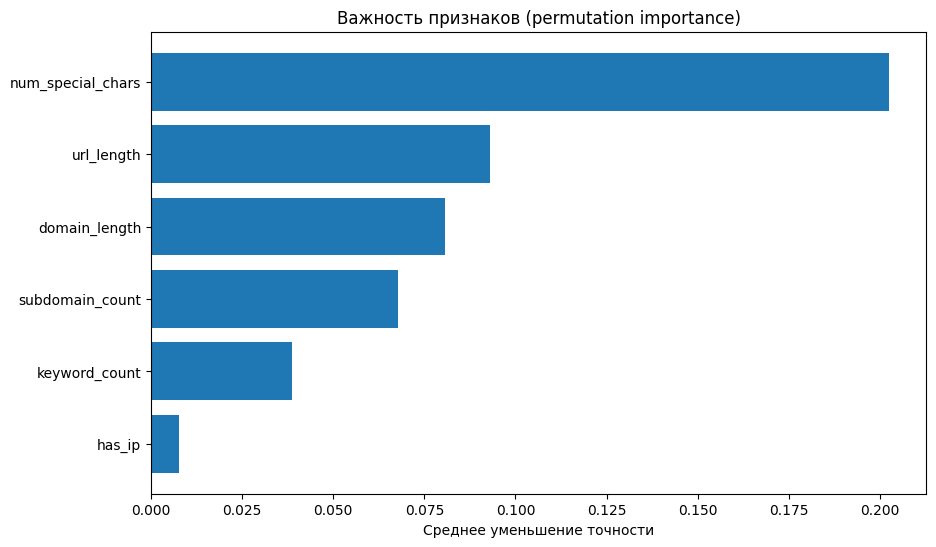

In [16]:
# Предсказание
y_pred = best_model.predict(X_test)
y_proba = best_model.predict_proba(X_test)[:, 1]

# Метрики
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

#print(f"\nROC-AUC: {roc_auc_score(y_test, y_proba, multi_class='ovr'):.2f}")

# Важность признаков
result = permutation_importance(
    best_model, 
    X_test, 
    y_test, 
    n_repeats=10, 
    random_state=42
)

# Визуализация
plt.figure(figsize=(10, 6))
sorted_idx = result.importances_mean.argsort()
plt.barh(
    np.array(features_df.columns)[sorted_idx], 
    result.importances_mean[sorted_idx]
)
plt.title("Важность признаков (permutation importance)")
plt.xlabel("Среднее уменьшение точности")
plt.show()